### PLACE ALL IMPORTS HERE (easier to keep track of)

In [323]:
# general
from __future__ import division
from collections import defaultdict
from collections import Counter
import os
import random
import re

# to read in JSON character objects 
import json

# for stopwords
import nltk
from nltk.tokenize import RegexpTokenizer

# for LDA topic modeling
from gensim import corpora, models, similarities, matutils

# for lots of math junk and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for making data frames
import pandas as pd
# for clustering, etc.
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

from scipy.cluster.hierarchy import ward, dendrogram
import scipy.stats as stats


# Read in character JSON, build feature vectors for a BOW-type model

Things to do: Fiddle with the mention threshold, dialogue features (to include or not to include?), maybe throw out the most common attributes afterward

**NOTE: All of this functionality is now located in the loadCharFeatures module**

getCharVectorsFromJson takes the following args:
    - mention_threshold (defaults to 100)
    - use_stopwords (defaults to true)
    - book_src_dir (pass in path to the raw book text)
    - json_filename (pass in path to the booknlp json file output)

In [324]:
import loadCharFeatures
reload(loadCharFeatures)
(characters, character_namelists, total_features, top_n) = loadCharFeatures.getCharVectorsFromJson()

Most common words in book:  [('the', 47552.0), ('to', 26268.0), ('and', 25179.0), ('of', 21444.0), ('a', 19852.0), ('.', 17618.0), ('was', 15155.0), ('he', 14435.0), ('his', 13612.0), ('said', 12682.0), ('in', 11952.0), ('Harry', 11326.0), ('had', 9954.0), ('that', 8840.0), ('at', 8322.0), ('you', 8044.0), ('it', 7310.0), ('I', 7282.0), ('as', 7026.0), ('with', 6272.0), ('on', 6097.0), ('for', 5193.0), ('He', 4990.0), ('not', 4666.0), ('\xc2\x91', 4527.0), ('her', 4418.0), ('they', 4259.0), ('be', 4258.0), ('were', 4155.0), ('but', 4010.0), ('from', 3997.0), ('have', 3970.0), ('out', 3847.0), ('him', 3806.0), ('\xe2\x80\x94', 3561.0), ('she', 3462.0), ('up', 3432.0), ('into', 3427.0), ('Ron', 3366.0), ('all', 3336.0), ('The', 3250.0), ('been', 3136.0), ('Hermione', 3119.0), ('what', 2798.0), ('could', 2668.0), ('back', 2595.0), ('who', 2581.0), ('their', 2497.0), ('is', 2491.0), ('them', 2482.0), ('Harry,', 2400.0), ('\xe2\x80\x9cI', 2326.0), ('looked', 2321.0), ('about', 2282.0), ('so

**Create texts to feed to gensim, print out BOW for each character**

In [325]:
texts = [None for key in characters]
names = {}
i = 0
for key, value in characters.iteritems():
    print str(key) + ": " + str(value)
    texts[i] = value
    names[key] = i
    i += 1
    print
print len(characters)

Parvati: [u'pipe_PATIENT', u'led_PATIENT', u'led_PATIENT', u'snap_PATIENT', u'join_PATIENT', u'pass_PATIENT', u'sigh_PATIENT', u'squeal_PATIENT', u'dart_PATIENT', u'overheard_PATIENT', u'hug_PATIENT', u'shot_AGENT', u'sit_AGENT', u'say_what_AGENT', u'scowl_AGENT', u'put_hand_AGENT', u'stare_AGENT', u'nudge_hard_AGENT', u'giggl_AGENT', u'wait_AGENT', u'giggl_AGENT', u'ad_AGENT', u'find_sist_AGENT', u'readjust_bangl_AGENT', u'gaze_AGENT', u'beam_AGENT', u'hiss_AGENT', u'seize_hand_AGENT', u'sat_AGENT', u'return_AGENT', u'sit_AGENT', u'tell_anybodi_AGENT', u'make_arrang_AGENT', u'nudge_lavend_AGENT', u'beam_AGENT', u'feel_AGENT', u'laugh_that_AGENT', u'say_what_AGENT', u'wear_what_AGENT', u'admir_AGENT', u'take_breath_AGENT', u'spend_rest_AGENT', u'produce_curs_AGENT', u'reduce_t_AGENT', u'squeal_AGENT', u'curl_eyelash_AGENT', u'bypass_staircas_AGENT', u'raise_hand_AGENT', u'lay_AGENT', u'draw_angl_AGENT', u'began_AGENT', u'practice_incant_AGENT', u'ran_AGENT', u'move_head_AGENT', u'give_

**Print most common features (to do: maybe filter these out of the model?)**

In [ ]:
counter = Counter(total_features)
top_n = counter.most_common(20)
print top_n
print

# remove these words from the texts before doing topic modeling
for text in texts:
    for word_tupe in top_n:
        while word_tupe[0] in text:
            text.remove(word_tupe[0])
#print texts

## Do LDA Topic Modeling Using Character Features

In [327]:
# create Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# create bag of words model to perform analysis
corpus = [dictionary.doc2bow(text) for text in texts]

numtopics = 12

lda = models.LdaModel(corpus, num_topics=numtopics, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=100, 
                            passes=100)


The following commented code is an attempt to determine the optimal number of clusters using the Arun, et al. measure. Implementation credit goes to Christopher Grainger (http://blog.cigrainger.com/2014/07/lda-number.html). However, we are not using it at this time because it takes too long/too much memory to run and doesn't necessarily produce useful results.

In [328]:
# Define KL function
# def sym_kl(p,q):
#     return np.sum([stats.entropy(p,q),stats.entropy(q,p)])

# l = np.array([sum(cnt for _, cnt in doc) for doc in corpus])
# def arun(corpus,dictionary,min_topics=1,max_topics=50,step=3):
#     kl = []
#     for i in range(min_topics,max_topics,step):
#         print i
#         lda = models.LdaModel(corpus=corpus,
#             id2word=dictionary,num_topics=i,passes=20)
#         m1 = lda.expElogbeta
#         U,cm1,V = np.linalg.svd(m1)
#         #Document-topic matrix
#         lda_topics = lda[corpus]
#         m2 = matutils.corpus2dense(lda_topics, lda.num_topics).transpose()
#         cm2 = l.dot(m2)
#         cm2 = cm2 + 0.0001
#         cm2norm = np.linalg.norm(l)
#         cm2 = cm2/cm2norm
#         kl.append(sym_kl(cm1,cm2))
#     return kl
    
# kl = arun(corpus,dictionary)
# # Plot kl divergence against number of topics
# plt.plot(kl)
# plt.ylabel('Symmetric KL Divergence')
# plt.xlabel('Number of Topics')
# plt.savefig('kldiv.png', bbox_inches='tight')

In [329]:
print(lda.show_topics())

[u'0.017*cage_POSS + 0.003*wing_POSS + 0.002*watch_PATIENT + 0.002*student_POSS + 0.002*hoot_AGENT + 0.002*sent_PATIENT + 0.002*return_AGENT + 0.002*school_SAY + 0.002*beak_POSS + 0.002*wife_POSS', u'0.012*yeh_SAY + 0.010*ter_SAY + 0.006*cabin_POSS + 0.004*fer_SAY + 0.004*o_SAY + 0.003*jus_SAY + 0.003*return_AGENT + 0.003*name_POSS + 0.003*mother_POSS + 0.003*hogwart_SAY', u'0.005*do_what_AGENT + 0.004*father_POSS + 0.003*laugh_AGENT + 0.003*detour_POSS + 0.002*say_what_AGENT + 0.002*smirk_AGENT + 0.002*sneer_AGENT + 0.002*mother_POSS + 0.002*die_AGENT + 0.002*letter_POSS', u'0.004*heart_POSS + 0.004*sure_MOD + 0.003*scar_POSS + 0.003*feel_AGENT + 0.003*glanc_AGENT + 0.003*found_AGENT + 0.003*realiz_AGENT + 0.002*stomach_POSS + 0.002*wonder_AGENT + 0.002*move_AGENT', u'0.007*master_SAY + 0.007*kreacher_SAY + 0.003*die_AGENT + 0.003*sit_AGENT + 0.002*regulus_SAY + 0.002*tale_POSS + 0.002*mr._SAY + 0.002*badg_POSS + 0.002*kill_PATIENT + 0.002*glass_POSS', u'0.003*ze_SAY + 0.002*glass_POS

#### Print top n words for each topic

Word Clouds for each topic generated using the wordcloud package - use "pip install wordcloud" (http://peekaboo-vision.blogspot.de/2012/11/a-wordcloud-in-python.html)

Topic  0
tonk_SAY phlegm_SAY ankl_POSS secret_POSS sprint_AGENT mum_SAY snitch_SAY horntail_SAY hug_good-by_AGENT carry_flag_AGENT do_it_AGENT letter_POSS hug__AGENT run_step_AGENT wherea_SAY play_seek_AGENT kiss_POSS diari_POSS snog_SAY d.a_SAY examin_POSS fleur_SAY glad_MOD met_AGENT sped_AGENT soul_POSS damn_SAY answer_PATIENT hem_SAY curl_PATIENT 


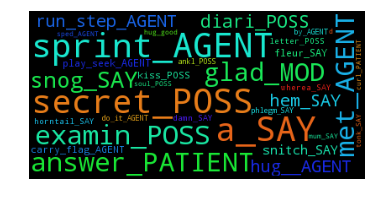

Topic  1
yeh_SAY yeh_SAY ter_SAY ter_SAY cabin_POSS fer_SAY o_SAY jus_SAY return_AGENT name_POSS mother_POSS hogwart_SAY yer_SAY soul_POSS bit_SAY tha_SAY support_POSS em_SAY father_POSS hut_POSS move_AGENT kill_PATIENT hous_POSS bin_SAY ask__AGENT stand_AGENT horcrux_POSS kill_SAY help_SAY righ_SAY gone_AGENT continu_AGENT 


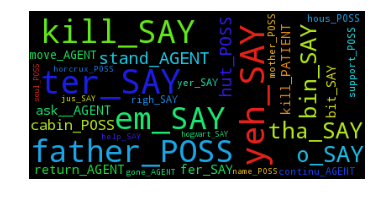

Topic  2
dobbi_SAY sir_SAY squeak_PATIENT son_POSS doe_SAY set_PATIENT boy_SAY howev_SAY winki_SAY grave_POSS shake_head_AGENT power_SAY vanish_AGENT call_AGENT do_it_AGENT hous_POSS friend_SAY alway_SAY leav_PATIENT lip_POSS shall_SAY pocket_POSS lord_SAY squeak_AGENT beam_AGENT sent_PATIENT sound_AGENT nod_AGENT sometim_SAY watch_PATIENT 


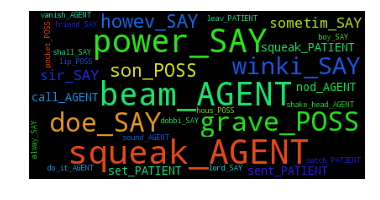

Topic  3
do_what_AGENT father_POSS laugh_AGENT detour_POSS say_what_AGENT smirk_AGENT sneer_AGENT mother_POSS die_AGENT letter_POSS sister_POSS mudblood_SAY stand_AGENT kill_PATIENT father_SAY hit_PATIENT glanc_AGENT ruff_POSS son_POSS strut_AGENT tone_POSS step_AGENT yeh_SAY disappear_AGENT spell_POSS open_ey_AGENT pull_AGENT keep_AGENT watch_PATIENT famili_POSS 


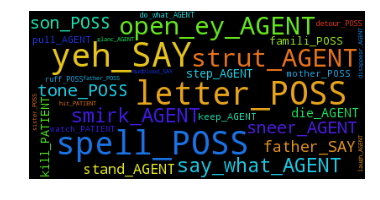

Topic  4
growl_AGENT growl_PATIENT roar_PATIENT stand_AGENT snigger_AGENT snarl_AGENT cloak_POSS mustach_POSS fist_POSS chuckl_AGENT offic_POSS hous_SAY flask_POSS roar_AGENT say_what_AGENT glare_AGENT follow_PATIENT point_AGENT talk_AGENT car_POSS move_AGENT attempt_AGENT laugh_AGENT boy_SAY stop_AGENT ad_AGENT bark_PATIENT give_SAY name_SAY be_what_AGENT 


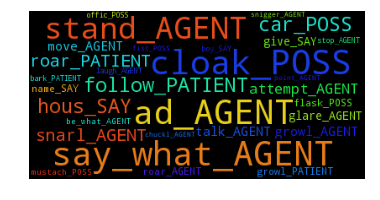

Topic  5
master_SAY kreacher_SAY die_AGENT sit_AGENT regulus_SAY tale_POSS mr._SAY badg_POSS kill_PATIENT glass_POSS crouch_SAY day_SAY sure_SAY letter_POSS hurri_AGENT watch_PATIENT croak_PATIENT shake_head_AGENT fight_SAY father_POSS sir_SAY appear_AGENT tell_they_AGENT chest_POSS return_AGENT boy_SAY mother_SAY cauldron_POSS order_SAY peev_SAY 


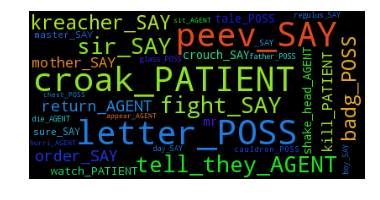

Topic  6
ze_SAY glass_POSS wizard_SAY kill_PATIENT knee_POSS sister_POSS ave_SAY daddi_SAY pleas_SAY lord_SAY pocket_POSS doe_SAY attack_PATIENT pull_PATIENT smile_AGENT boy_SAY watch_POSS molli_SAY father_POSS ad_AGENT dark_SAY thank_SAY vanish_AGENT find_SAY pant_AGENT talk_AGENT wife_POSS chest_POSS sit_AGENT stand_AGENT 


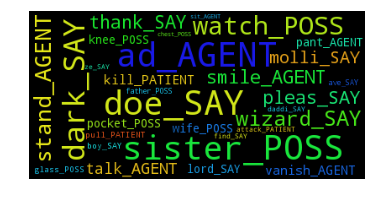

Topic  7
doe_SAY ad_AGENT year_SAY magic_SAY sure_SAY sit_AGENT smile_AGENT bit_SAY ministri_SAY anyth_SAY dark_SAY happen_SAY school_SAY find_SAY pocket_POSS offic_POSS stand_AGENT continu_AGENT death_SAY give_SAY stop_AGENT start_AGENT move_AGENT stop_SAY hogwart_SAY keep_SAY sorri_SAY ask__AGENT wizard_SAY suppos_SAY 


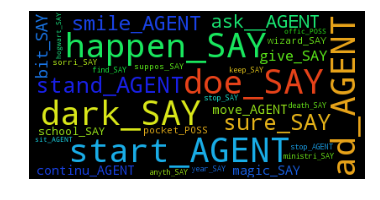

Topic  8
offic_POSS clipboard_POSS dear_SAY son_POSS father_SAY arthur_SAY ad_AGENT magic_SAY ministri_SAY husband_POSS hem_SAY appear_AGENT move_AGENT smile_POSS lip_POSS master_SAY shall_SAY ought_SAY snap_AGENT suppos_SAY say_what_AGENT desk_POSS better_SAY talk_AGENT sit_AGENT call_AGENT wizard_SAY chair_POSS pleas_SAY night_SAY 


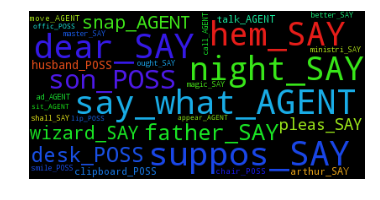

Topic  9
cage_POSS cage_POSS wing_POSS watch_PATIENT student_POSS hoot_AGENT sent_PATIENT return_AGENT school_SAY beak_POSS wife_POSS send_PATIENT join_PATIENT land_AGENT gone_AGENT kept_AGENT feather_POSS understand_SAY moodi_SAY caught_PATIENT allow_SAY charm_SAY given_SAY reflect_POSS protect_SAY bound_PATIENT present_SAY lift_PATIENT agre_SAY point_SAY wing_SAY 


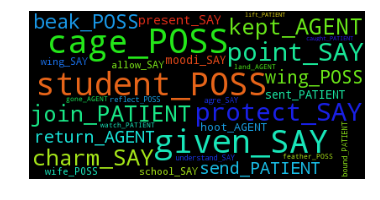

Topic  10
heart_POSS sure_MOD scar_POSS feel_AGENT glanc_AGENT found_AGENT realiz_AGENT stomach_POSS wonder_AGENT move_AGENT glass_POSS bed_POSS chest_POSS trunk_POSS forehead_POSS knee_POSS start_AGENT ask__AGENT notic_AGENT watch_PATIENT er_SAY life_POSS throat_POSS dark_SAY hurri_AGENT watch_AGENT rememb_AGENT abl_MOD doe_SAY pocket_POSS 


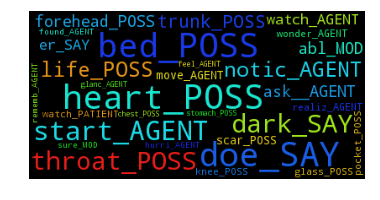

Topic  11
diari_POSS friend_POSS father_POSS tom_SAY tell_i_AGENT scream_AGENT mother_POSS stop_AGENT brother_POSS school_SAY name_POSS sir_SAY sister_POSS nod_AGENT stand_AGENT room_POSS watch_PATIENT move_AGENT laugh_AGENT start_AGENT get_award_AGENT word_POSS wizard_SAY pocket_POSS attack_SAY express_POSS die_AGENT smile_AGENT ad_AGENT sigh_AGENT 


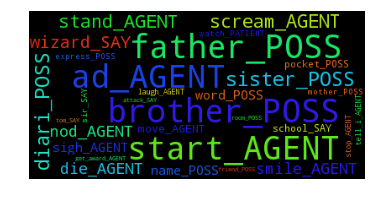

In [330]:
from wordcloud import WordCloud

%matplotlib inline
top_texts = []
for i in range(0, numtopics):
    print 'Topic ', i
    text = ""
    word_tups = lda.show_topic(i, 30)
    for tup in word_tups:
        scale = (int)(tup[0]*100 + 1)
        for i in range(scale):
            text += (tup[1])
            text += " "
    print text
    img = WordCloud(max_font_size=40, relative_scaling=.1).generate(text)
    # Display the generated image:
    plt.imshow(img)
    plt.axis("off")
    plt.show()


#### Create topic matrix (dimensions num_characters x num_topics) containing topic probabilities for each character

In [331]:
topic_matrix = [[0 for i in range(numtopics)] for namekey in names]
print len(topic_matrix)
i = 0
for namekey in names:
    print i, str(namekey) + " topic distribution: "
    for (key, value) in lda[corpus[names[namekey]]]:
        topic_matrix[i][key] = value
    i+=1
    print lda[corpus[names[namekey]]]

66
0 Petunia Dursley topic distribution: 
[(11, 0.99517535240298161)]
1 Parvati topic distribution: 
[(8, 0.99604877175149864)]
2 Mr. Weasley topic distribution: 
[(6, 0.9988968912869236)]
3 Lupin topic distribution: 
[(7, 0.99897919665727464)]
4 Krum topic distribution: 
[(4, 0.99599702923221223)]
5 Fleur topic distribution: 
[(6, 0.99669068815930195)]
6 Vernon Dursley topic distribution: 
[(4, 0.99865391956640481)]
7 Wood topic distribution: 
[(10, 0.99637674587899328)]
8 Quirrell topic distribution: 
[(4, 0.9865193444788195)]
9 George topic distribution: 
[(7, 0.99875788397088683)]
10 Tom Riddle topic distribution: 
[(11, 0.99822002725291825)]
11 Hufflepuff topic distribution: 
[(10, 0.95833293383791895)]
12 Ginny topic distribution: 
[(0, 0.30787034097022598), (7, 0.69127406438189853)]
13 Sirius topic distribution: 
[(7, 0.99945239821708876)]
14 Crabbe topic distribution: 
[(4, 0.99437618530028216)]
15 Percy topic distribution: 
[(5, 0.99859619573886216)]
16 Flitwick topic distribu

#### Bar plot visualization of above character topic probabilities

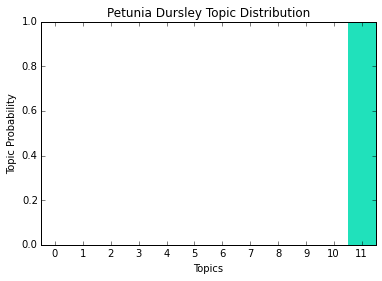

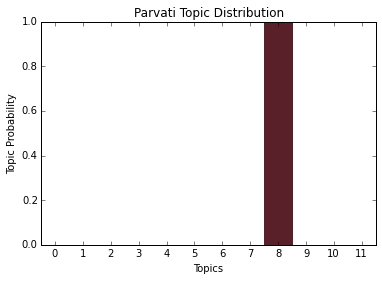

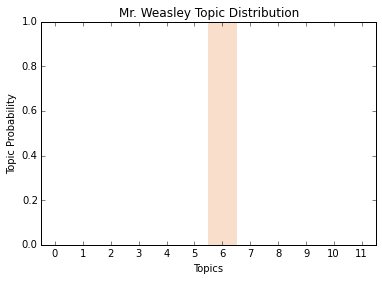

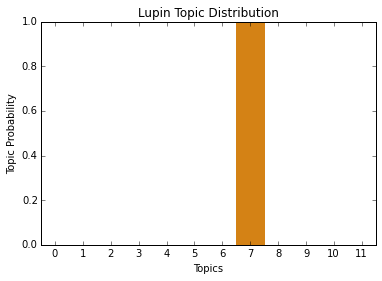

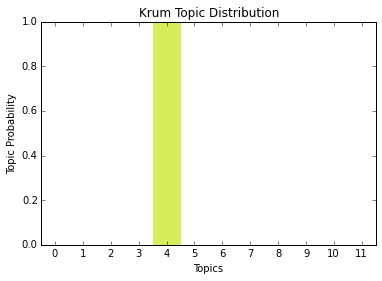

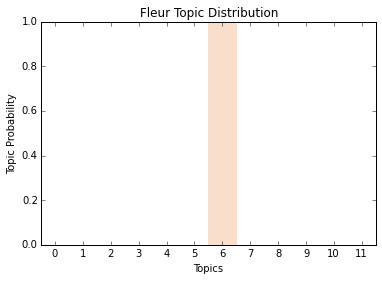

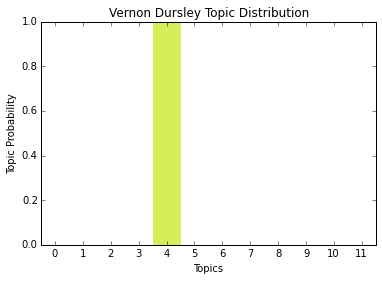

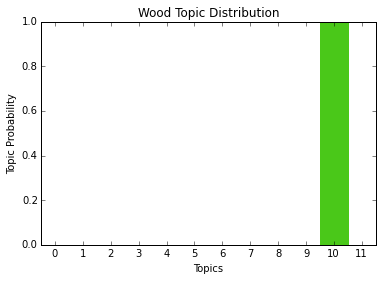

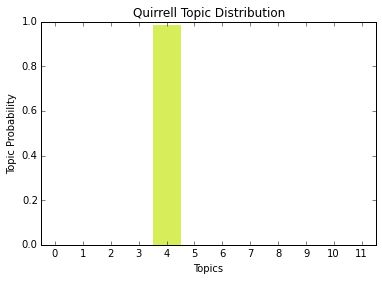

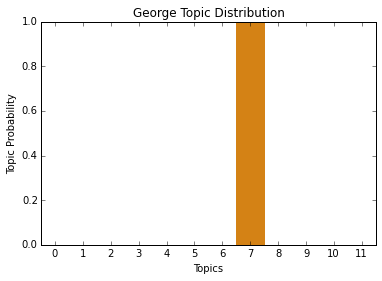

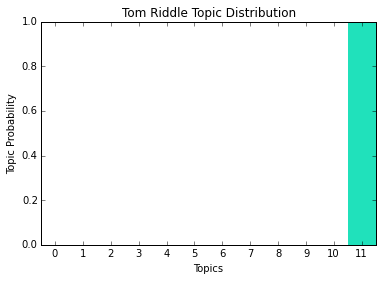

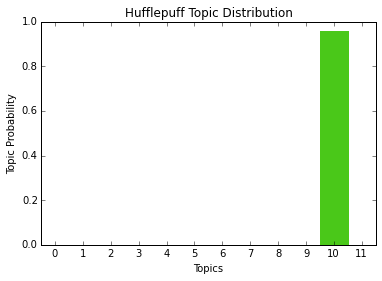

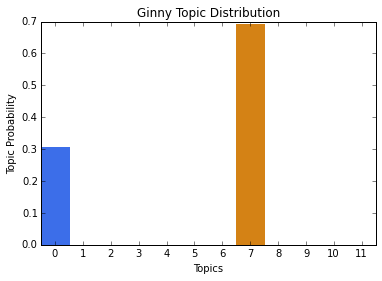

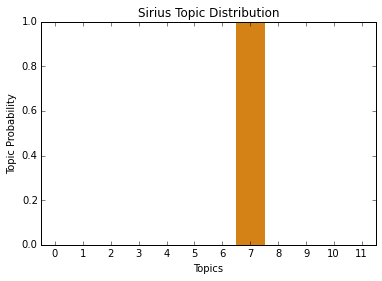

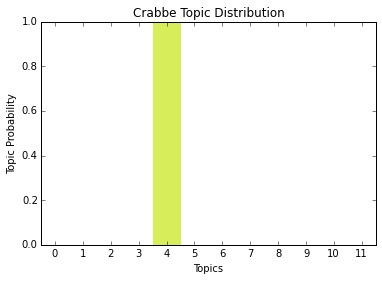

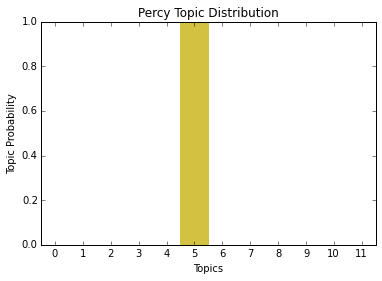

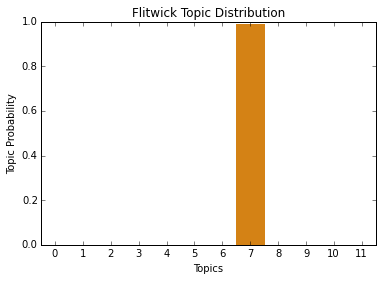

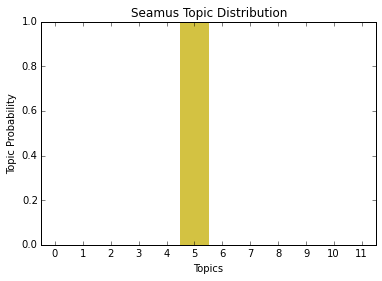

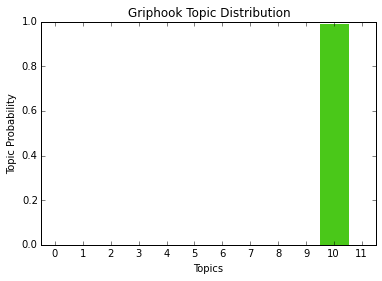

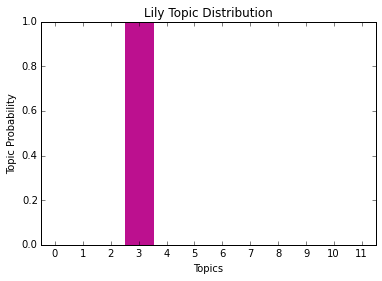

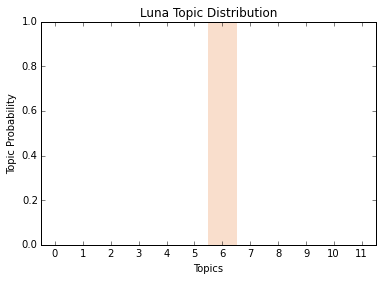

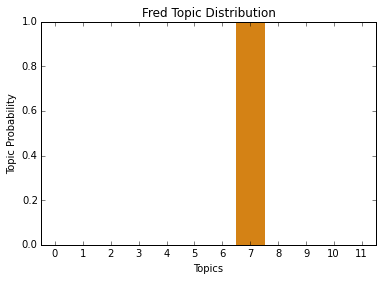

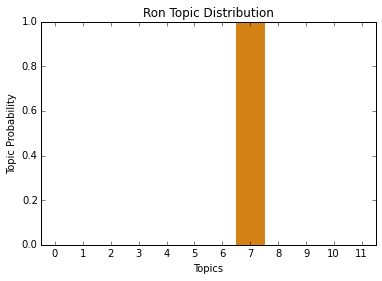

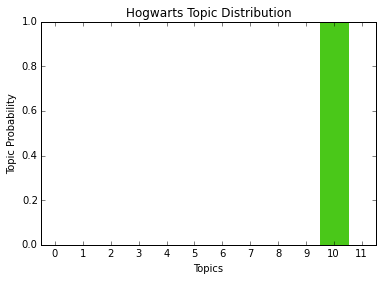

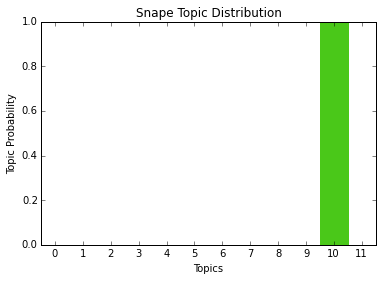

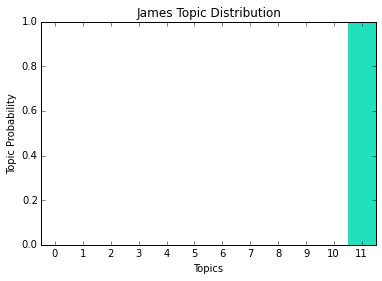

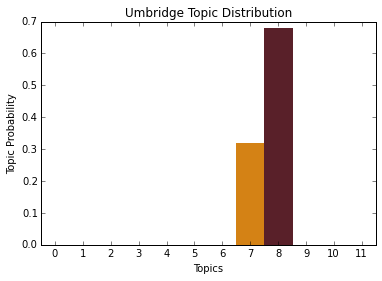

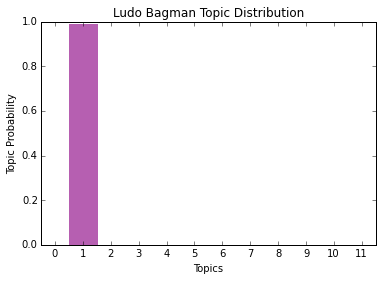

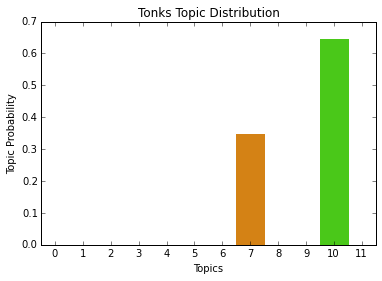

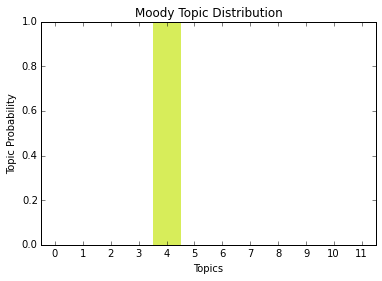

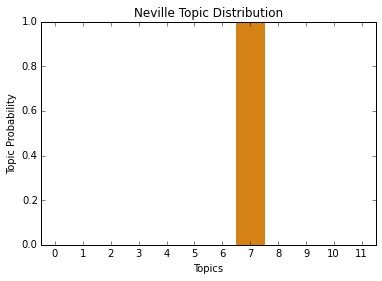

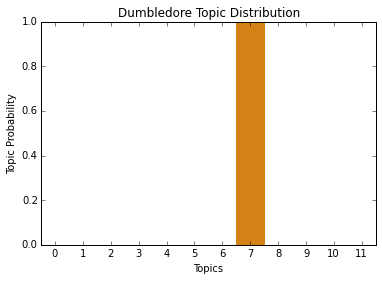

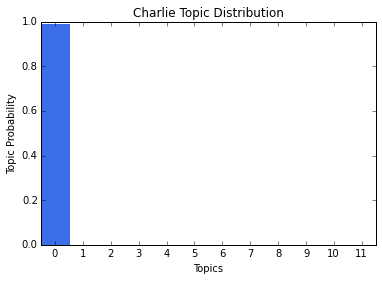

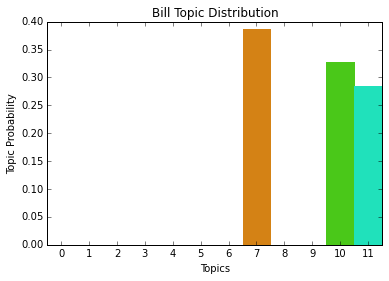

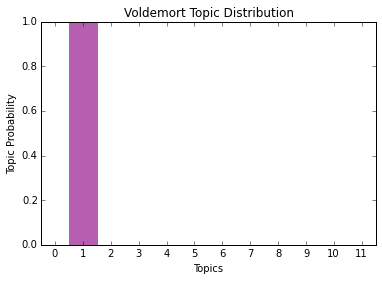

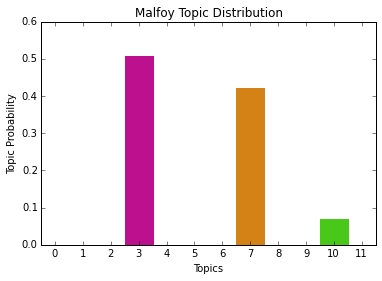

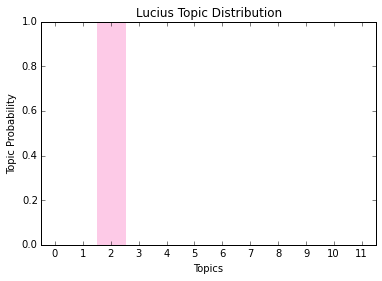

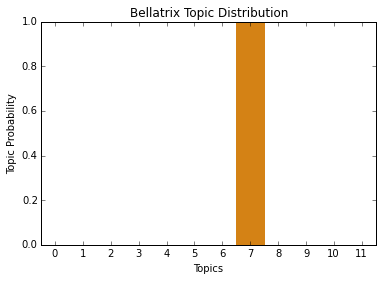

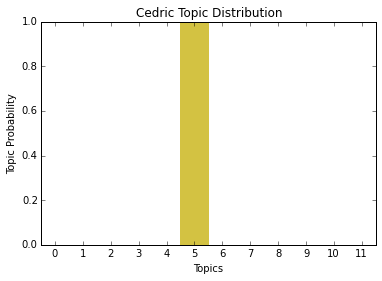

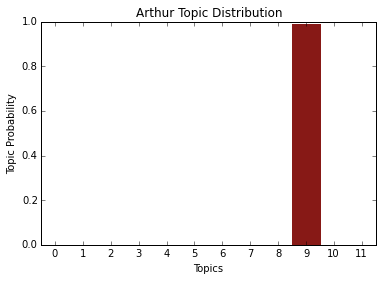

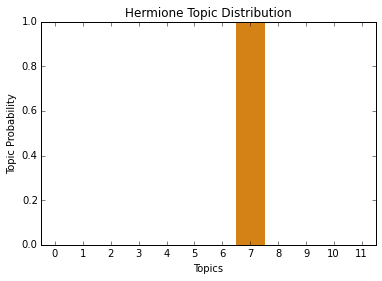

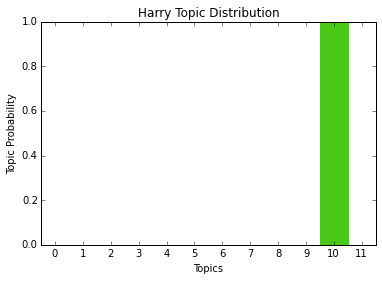

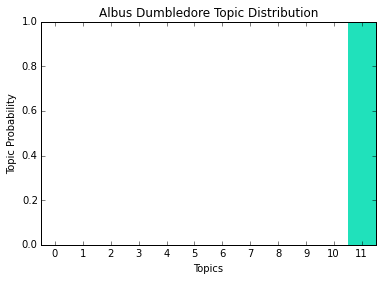

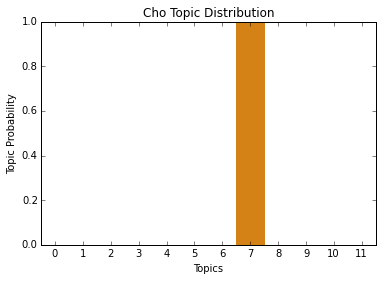

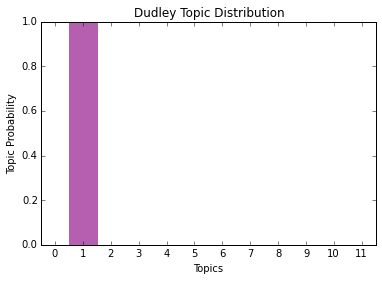

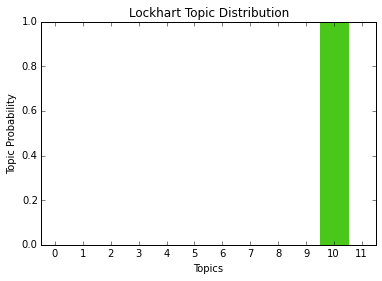

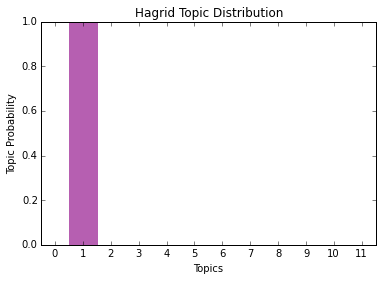

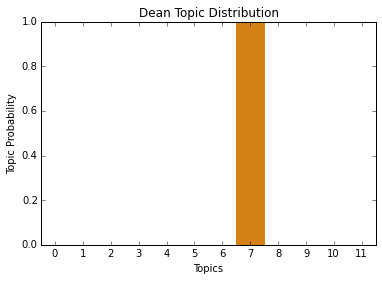

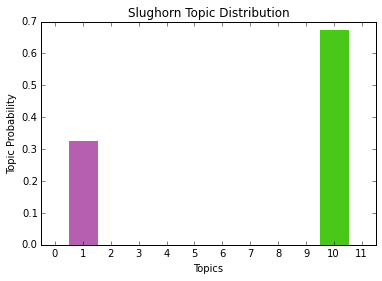

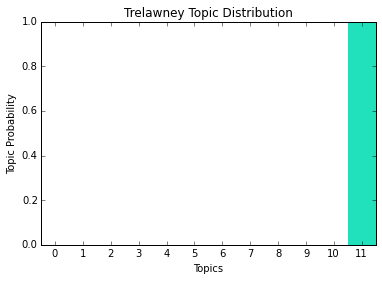

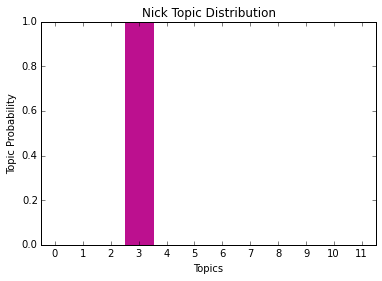

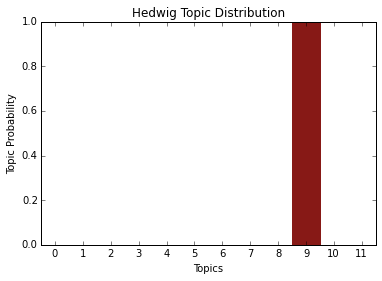

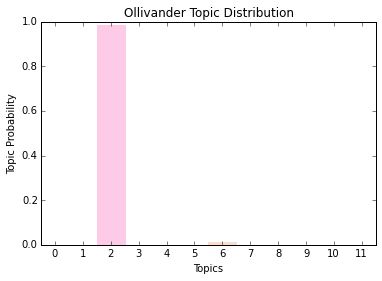

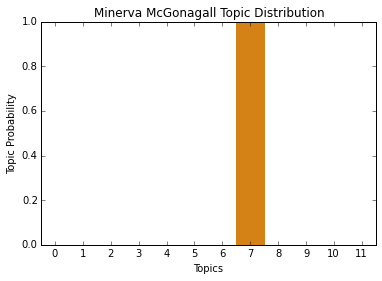

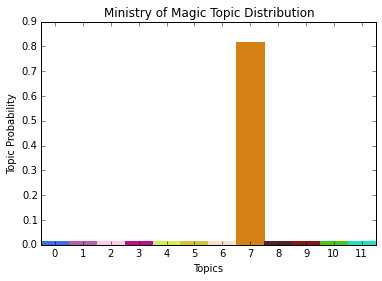

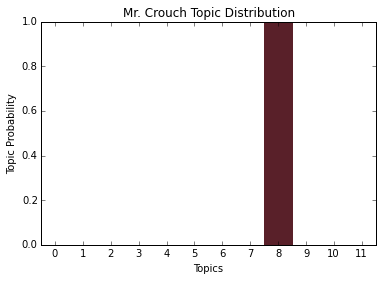

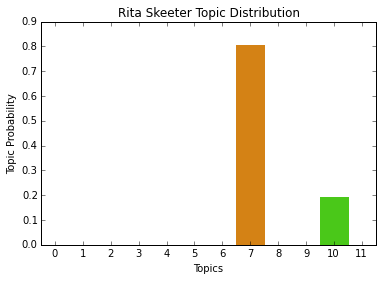

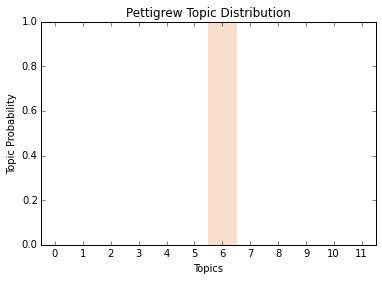

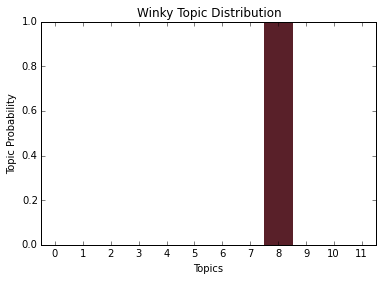

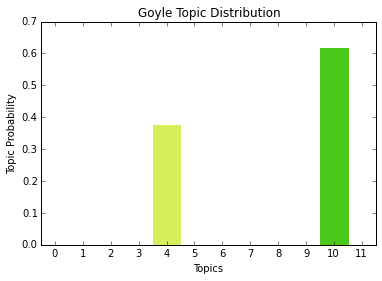

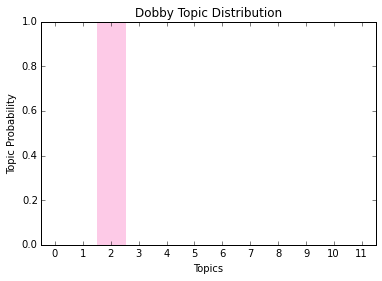

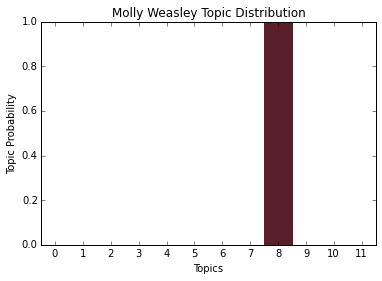

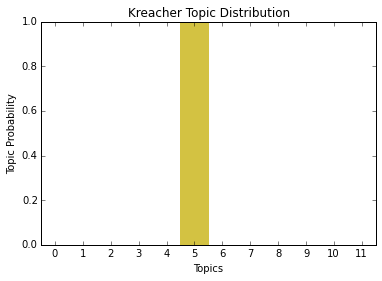

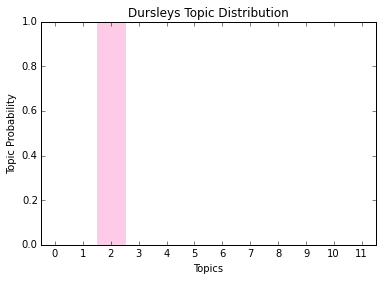

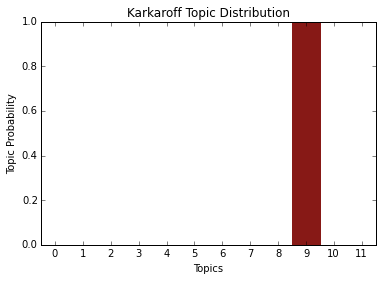

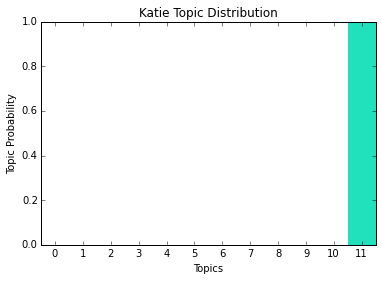

In [332]:
# Plot bar charts for each character's topics

# choose some random colors to represent each topic
topicColors = []
for i in range(numtopics):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    topicColors.append(color)

%matplotlib inline 

# iterate through the character topic vectors, making a plot for each
nameit = names.iterkeys()
for charArray in topic_matrix:
    ind = np.arange(len(charArray))  # the x locations for the topics
    fig, ax = plt.subplots()
    width = 1
    
    topicNames = []
    topicProbs = []
    for i in range(len(charArray)):
        topicNames.append(i)
    
    rects1 = ax.bar(ind, charArray, width)
    for i in range(len(charArray)):
        rects1[i].set_color(topicColors[topicNames[i]])
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Topic Probability')
    ax.set_xlabel('Topics')
    title =  nameit.next() + ' Topic Distribution'
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(topicNames)
    plt.show()


## Perform Clustering Based on Character Topic Vectors

The following code is heavily derivative of Brandon Rose's tutorial on topic modeling and clustering. 
http://brandonrose.org/clustering

#### Use KMeans (is this the best choice?) and print out the clusters list

In [333]:
data = np.array(topic_matrix)

from sklearn.cluster import KMeans
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)
clusters = kmeans.labels_.tolist()
print clusters
# "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."
goodness = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
print "silhouette score: " + str(goodness)
# within-cluster sum of squares
print "inertia: " + str(kmeans.inertia_)

[0, 3, 5, 4, 6, 5, 6, 1, 6, 4, 0, 1, 4, 4, 6, 7, 4, 7, 1, 2, 5, 4, 4, 1, 1, 0, 3, 2, 1, 6, 4, 4, 2, 2, 2, 2, 2, 4, 7, 2, 4, 1, 0, 4, 2, 1, 2, 4, 1, 0, 2, 2, 2, 4, 4, 3, 4, 5, 3, 1, 2, 3, 7, 2, 2, 0]
silhouette score: 0.705544987965
inertia: 12.5786518575


#### Print out characters and cluster assignments (in order)

In [334]:
dic={}
i=0
for nameKey in names:
    dic[str(nameKey)]=clusters[i]
    i += 1
d=sorted(dic.items(), key=lambda x:x[1])
for name in d:
    print name

('Trelawney', 0)
('Petunia Dursley', 0)
('Tom Riddle', 0)
('James', 0)
('Albus Dumbledore', 0)
('Katie', 0)
('Wood', 1)
('Hufflepuff', 1)
('Hogwarts', 1)
('Snape', 1)
('Tonks', 1)
('Harry', 1)
('Lockhart', 1)
('Slughorn', 1)
('Griphook', 1)
('Goyle', 1)
('Dursleys', 2)
('Dudley', 2)
('Lily', 2)
('Karkaroff', 2)
('Charlie', 2)
('Dobby', 2)
('Ludo Bagman', 2)
('Bill', 2)
('Voldemort', 2)
('Malfoy', 2)
('Arthur', 2)
('Hagrid', 2)
('Nick', 2)
('Hedwig', 2)
('Ollivander', 2)
('Lucius', 2)
('Parvati', 3)
('Umbridge', 3)
('Mr. Crouch', 3)
('Molly Weasley', 3)
('Winky', 3)
('Rita Skeeter', 4)
('Lupin', 4)
('Sirius', 4)
('Cho', 4)
('Ginny', 4)
('Fred', 4)
('Neville', 4)
('Dumbledore', 4)
('Bellatrix', 4)
('Hermione', 4)
('Flitwick', 4)
('Dean', 4)
('Ron', 4)
('Minerva McGonagall', 4)
('Ministry of Magic', 4)
('George', 4)
('Mr. Weasley', 5)
('Fleur', 5)
('Pettigrew', 5)
('Luna', 5)
('Krum', 6)
('Quirrell', 6)
('Crabbe', 6)
('Moody', 6)
('Vernon Dursley', 6)
('Kreacher', 7)
('Cedric', 7)
('Seamu

#### Create data frame for clusters and characters

In [335]:
tempNameList = [nameKey for nameKey in names]
charClusts = {'characters': tempNameList, 'clusters': clusters}
frame = pd.DataFrame(charClusts, index = [clusters] , columns = ['character', 'clusters'])

In [336]:
frame['clusters'].value_counts() 

4    16
2    16
1    10
0     6
6     5
3     5
7     4
5     4
Name: clusters, dtype: int64

#### Show visual cluster plot 

In [337]:
# get euclidean distance between each character's topic vector
dist = euclidean_distances(data, data)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
    
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tempNameList)) 

#group by cluster
groups = df.groupby('label')

In [338]:
# assign cluster colors and names
cluster_colors = defaultdict(None)
cluster_names = defaultdict(None)
# randomly generate n colors based on the number of clusters desired
for i in range(len(clusters)):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    cluster_colors[i] = color
    cluster_names[i] = i

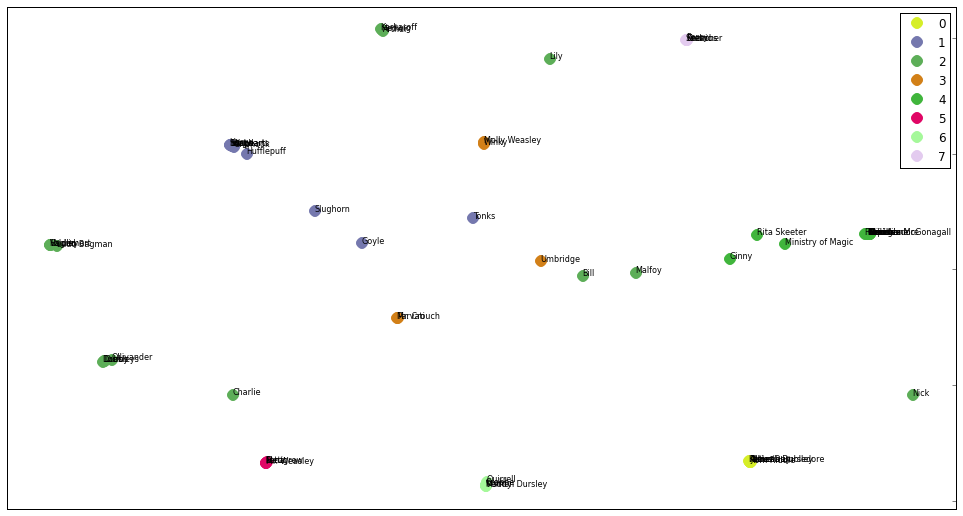

In [339]:
#The following is taken word for word from this tutorial: http://brandonrose.org/clustering

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



plt.show() #show the plot


In [340]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)
plt.close()

#### Create and show dendrogram for the characters 

Again, taken almost verbatim from Brandon Rose's tutorial, implementation credit goes to him

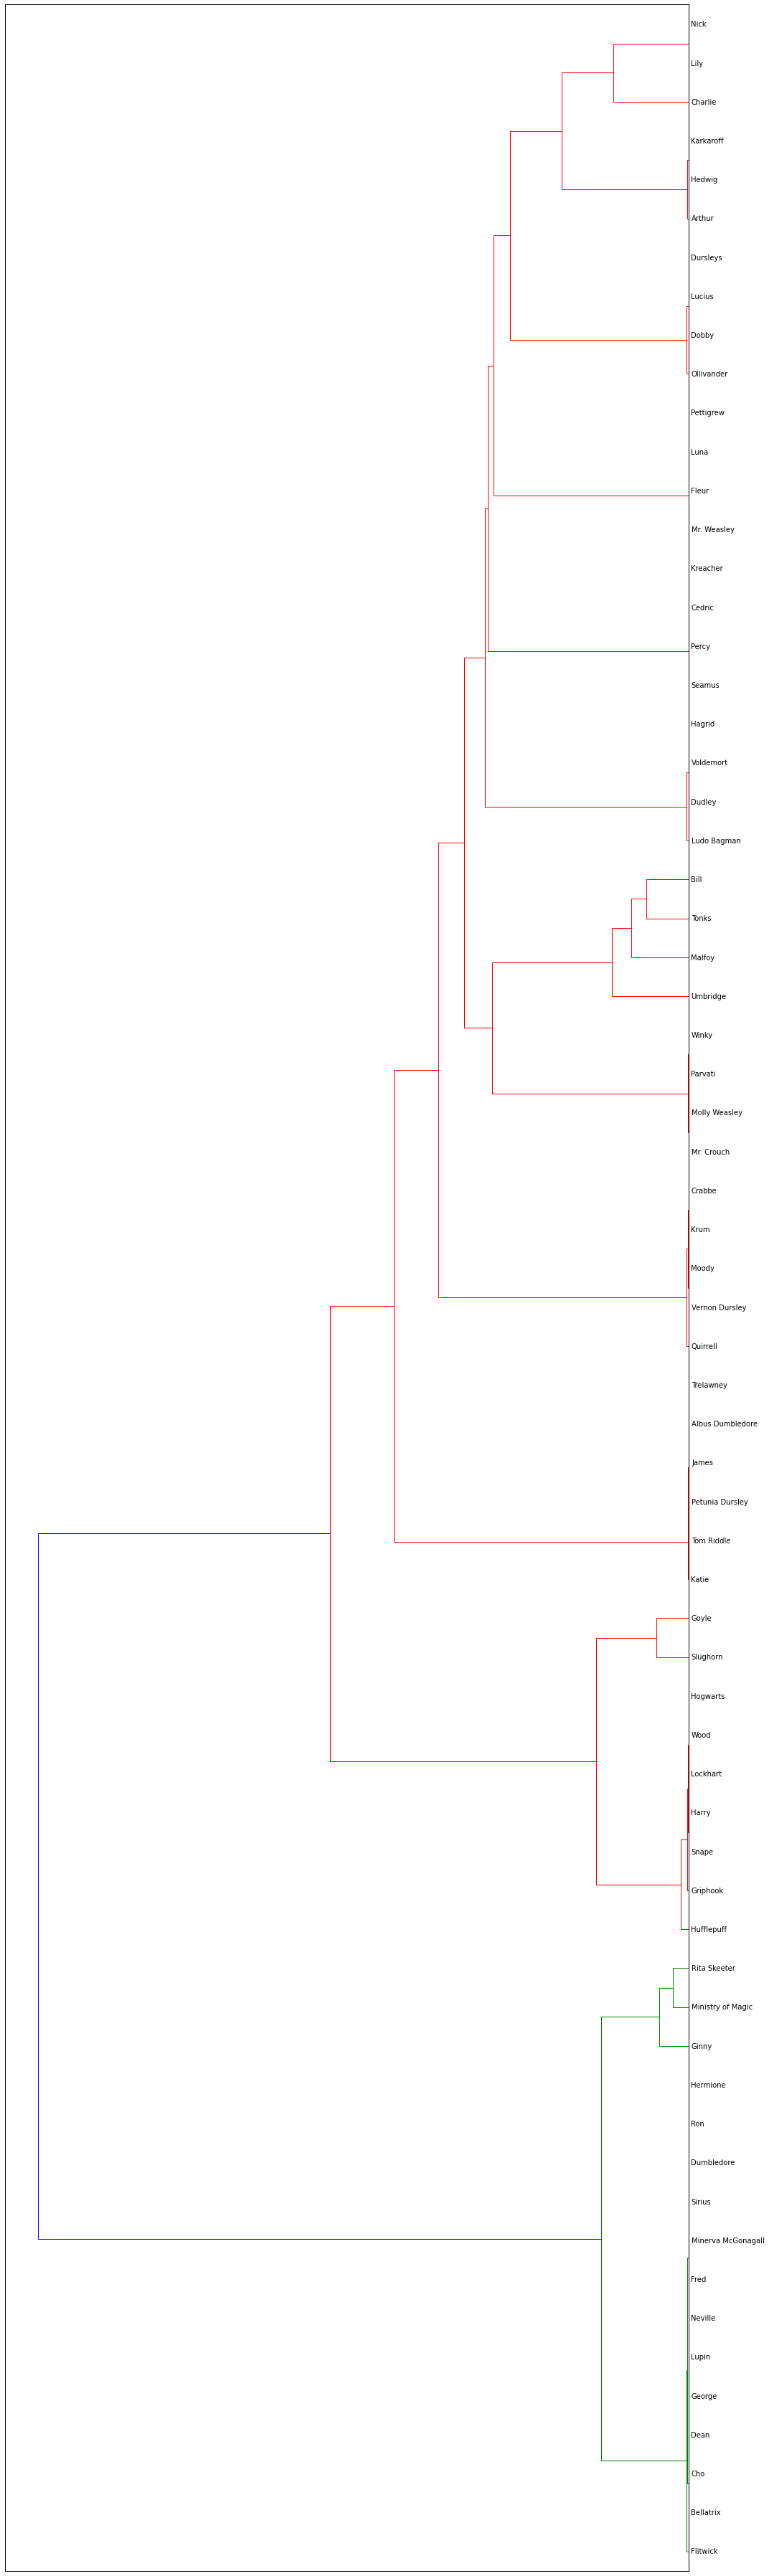

In [341]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=charClusts['characters']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Supervised Learning with Topics

 What follows is an attempt to use the characters' generated topic probabilities as features for supervised learning (specifically logistic regression). Based on our ground truth labeled information, we will see whether the topic assignments are informative/useful for predicting these labels or not.

In [342]:
# load our labeled character data (choose one of our annotated character files)
import getVectors
getVectors = reload(getVectors)
# labels = ['Muggles', 'Hogwarts Students', 'Hogwarts Teachers', 'Ministry Officials', 
#           'Quidditch Players', 'Gryffindors', 'Ravenclaws', 'Hufflepuffs','Slytherins',
#          'Muggle-borns','Purebloods','Half-bloods','Humans','Part Humans', 'Non-Humans',
#          'Death Eaters', 'Order of the Phoenix', 'Dumbledores Army','Animagi', 'Parselmouths',
#          'Convicts','Weasleys','Dead','Bullies', 'Victims']
#(vectors, charlist) = getVectors.getVectors("cluster.txt")
labels = ['Protagonists', 'Antagonists', 'Neutral', 'Animals']
(vectors, charlist) = getVectors.getVectors("good_bad_labels.txt")
print charlist

['Lupin', 'Cho', 'Albus Dumbledore', 'Lily', 'Cedric', 'Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Fred Weasley', 'George Weasley', 'Neville Longbottom', 'Ginny Weasley', 'Luna Lovegood', 'Dean Thomas', 'Oliver Wood', 'Rubeus Hagrid', 'Minerva McGonagall', 'Mad-Eye Moody', 'Arthur Weasley', 'Mr. Weasley', 'Tonks', 'Kingsley Shacklebolt', 'Viktor Krum', 'Sirius Black', 'Bill', 'Godric Gryffindor', 'Mrs. Weasley', 'Regulus', 'Fleur Delacour', 'Dobby', 'James Potter', 'Dudley', 'Malfoys', 'Yaxley', 'Goyle', 'Phineus Nigelus', 'Quirrell', 'Mr. Dursley', 'Mrs. Dursley', 'Aunt Marge', 'Draco Malfoy', 'Crabbe', 'Pansy Parkinson', 'Zacharias Smith', 'Montague', 'Severus Snape', 'Dolores Umbridge', 'Lucius', 'Cornelius Fudge', 'Barty Crouch', 'Peter Pettigrew', 'Voldemort', 'Bellatrix Lestrange', 'Salazar Slytherin', 'Narcissa Malfoy', 'Morfin', 'Antonin Dolohov', 'Rita Skeeter', 'Igor Karkaroff', 'Filch', 'Macnair', 'Travers', 'Fenrir Greyback', 'Kreacher', 'Griphook', 'Madam Hooch', '

In [343]:
# shuffle our samples
# combined = zip(charlist, vectors)
# random.shuffle(combined)
# charlist[:], vectors[:] = zip(*combined)

# just checking to make sure the vectors look right
# for i in range(len(vectors)):
#     print charlist[i]
#     print vectors[i]

In [344]:
# get a list of the indices for labeled characters that were recognized by book-nlp 
# (if they weren't returned in the character list, we can't classify them)
labeled = {}
j = 0 # index of character in labeled character list
for name in charlist:
    i = 0 # index of character in topic model vectors list
    found = False
    for name2 in names:
        #print name2
        if name.encode('UTF-8') in character_namelists[name2]:
            found = True
        elif not found == True:
            i+=1
    if found:
        # print name.encode('UTF-8')
        # tupe is topic vector index, charlist index
        labeled[name] = (j, i)
    #else:
        #print name.encode('UTF-8')
    j+=1
num_samples = len(labeled)
print num_samples

55


In [345]:
#print len(topic_matrix)
matrix = []
labeled_topic_matrix = []
labeled_chars = []
for char in labeled:
    #print char
    (charNameIndex, charTopicIndex) = labeled[char]
    print charNameIndex, charTopicIndex
    print charlist[charNameIndex]
    labeled_chars.append(charlist[charNameIndex])
    print vectors[charNameIndex]
    matrix.append(vectors[charNameIndex])
    print topic_matrix[charTopicIndex]              
    labeled_topic_matrix.append(topic_matrix[charTopicIndex])
    print

labeled_topic_matrix = np.array(labeled_topic_matrix) 
#print labeled_topic_matrix

labelmatrix = np.matrix(matrix)
#print labelmatrix

5 41
Harry Potter
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99997054552119924, 0]

17 29
Mad-Eye Moody
[1, 0, 0, 0]
[0, 0, 0, 0, 0.99848981114456625, 0, 0, 0, 0, 0, 0, 0]

11 12
Ginny Weasley
[1, 0, 0, 0]
[0.30787033601193492, 0, 0, 0, 0, 0, 0, 0.69127406934038094, 0, 0, 0, 0]

45 24
Severus Snape
[0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99945748306535565, 0]

19 2
Mr. Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0.99889689065860643, 0, 0, 0, 0, 0]

52 37
Bellatrix Lestrange
[0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0.99622762965761447, 0, 0, 0, 0]

0 3
Lupin
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0.99897919529678891, 0, 0, 0, 0]

31 44
Dudley
[0, 1, 0, 0]
[0, 0.99823714480711023, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1 43
Cho
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0.99496326950158731, 0, 0, 0, 0]

18 39
Arthur Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.98882094606447624, 0, 0]

99 45
Gilderoy Lockhart
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99767339167411362, 0]

28 5
Fleur Delacour
[1, 0

In [346]:
from sklearn import linear_model
from sklearn import cross_validation


# choose the appropriate row to get your binary labels for feature i, then split it into a train/test set
# i.e. Muggles vs. not muggles, good guys vs. not good guys, etc.
for label in range(labelmatrix[0].size):
    print labels[label]
    #X_train, X_test, y_train, y_test = cross_validation.train_test_split(labeled_topic_matrix, labelmatrix[:,label], test_size=0.4, random_state=0)
    logreg = linear_model.LogisticRegression(C=1e5)
    # train
    #logreg.fit(X_train, y_train)
    #Z = logreg.predict(X_test)
    #print "accuracy: ", logreg.score(X_test, y_test)
    # print Z
    print "Accuracy:"
    accuracyScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2)
    print accuracyScores
    print "Precision:"
    precisionScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'precision')
    print precisionScores
    print "Recall:"
    recallScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'recall')
    print recallScores
    print

Protagonists
Accuracy:
[ 0.53571429  0.59259259]
Precision:
[ 0.52941176  0.57142857]
Recall:
[ 0.64285714  0.61538462]

Antagonists
Accuracy:
[ 0.60714286  0.59259259]
Precision:
[ 0.   0.3]
Recall:
[ 0.          0.42857143]

Neutral
Accuracy:
[ 0.78571429  0.66666667]
Precision:
[ 0.5         0.28571429]
Recall:
[ 0.5         0.33333333]

Animals
Accuracy:


C:\Users\Molly\Anaconda\lib\site-packages\sklearn\cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0